# Style transfer using GAN
This notebook will be used to prepare the capstone project 'Style transfer using GAN'

In [37]:
#Import all the required libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
import imageio
import glob
import os
import pandas as pd
from PIL import Image

## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)


In [38]:
BATCH_SIZE = 1
IMAGE_SIZE = (32, 32)

In [39]:
t1_directory = r'D:\Pratik\Style Transfer with GAN 256x256\GAN data\Tr1\TrainT1'
t2_directory = r'D:\Pratik\Style Transfer with GAN 256x256\GAN data\Tr2\TrainT2'

In [40]:
def image_to_np_array(image_path):
    """
    Read an image from file and convert it to a numpy array.
    """
    image = Image.open(image_path)
    return np.array(image)

def read_images_to_dataframe(image_dir):
    """
    Read all images from the specified directory into a Pandas DataFrame.
    """
    image_data = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(image_dir, filename)
            image_array = image_to_np_array(image_path)
            image_data.append({'filename': filename, 'image_array': image_array})
    return pd.DataFrame(image_data)

# Example usage:
t1_data_raw = read_images_to_dataframe(t1_directory)
t2_data_raw = read_images_to_dataframe(t2_directory)
t1_data = t1_data_raw['image_array']
t2_data = t2_data_raw['image_array']
t1_data = (t1_data/127.5) - 1
t2_data = (t2_data/127.5) - 1
print(t1_data.head())
print(t2_data.head())

0    [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...
1    [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...
2    [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...
3    [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...
4    [[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...
Name: image_array, dtype: object
0    [[-0.9764705882352941, -0.9686274509803922, -0...
1    [[-0.9764705882352941, -0.9686274509803922, -0...
2    [[-0.9764705882352941, -0.9686274509803922, -0...
3    [[-0.9764705882352941, -0.9686274509803922, -0...
4    [[-0.9764705882352941, -0.9764705882352941, -0...
Name: image_array, dtype: object


## Image Processing 
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets 

3.Visualise the MRI images after processing




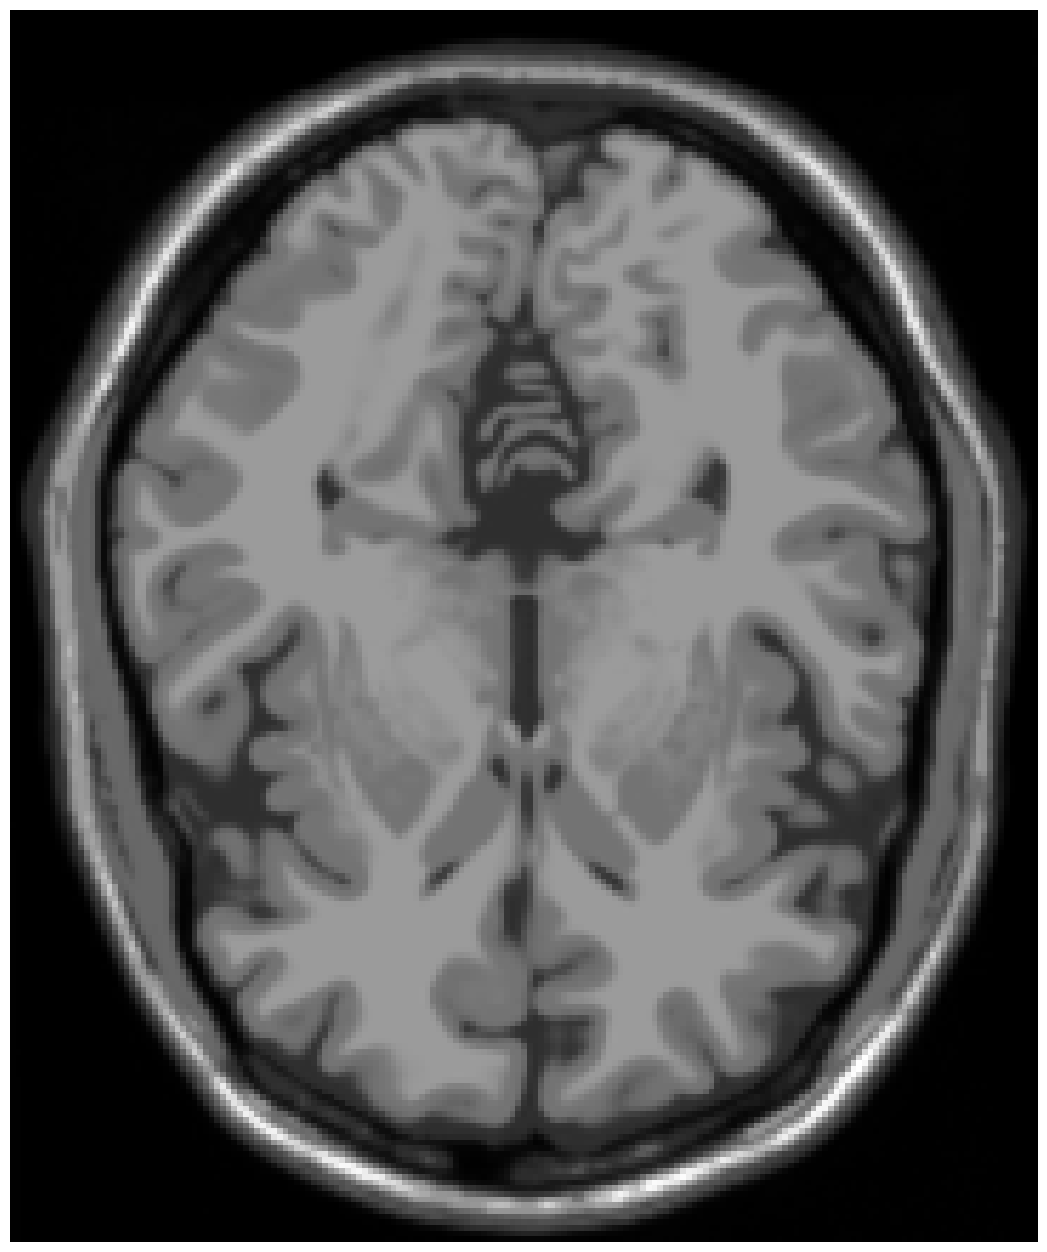

In [41]:
plt.figure(figsize=(16, 16))
plt.imshow(t1_data[0], cmap='gray')
plt.axis('off')
plt.show()


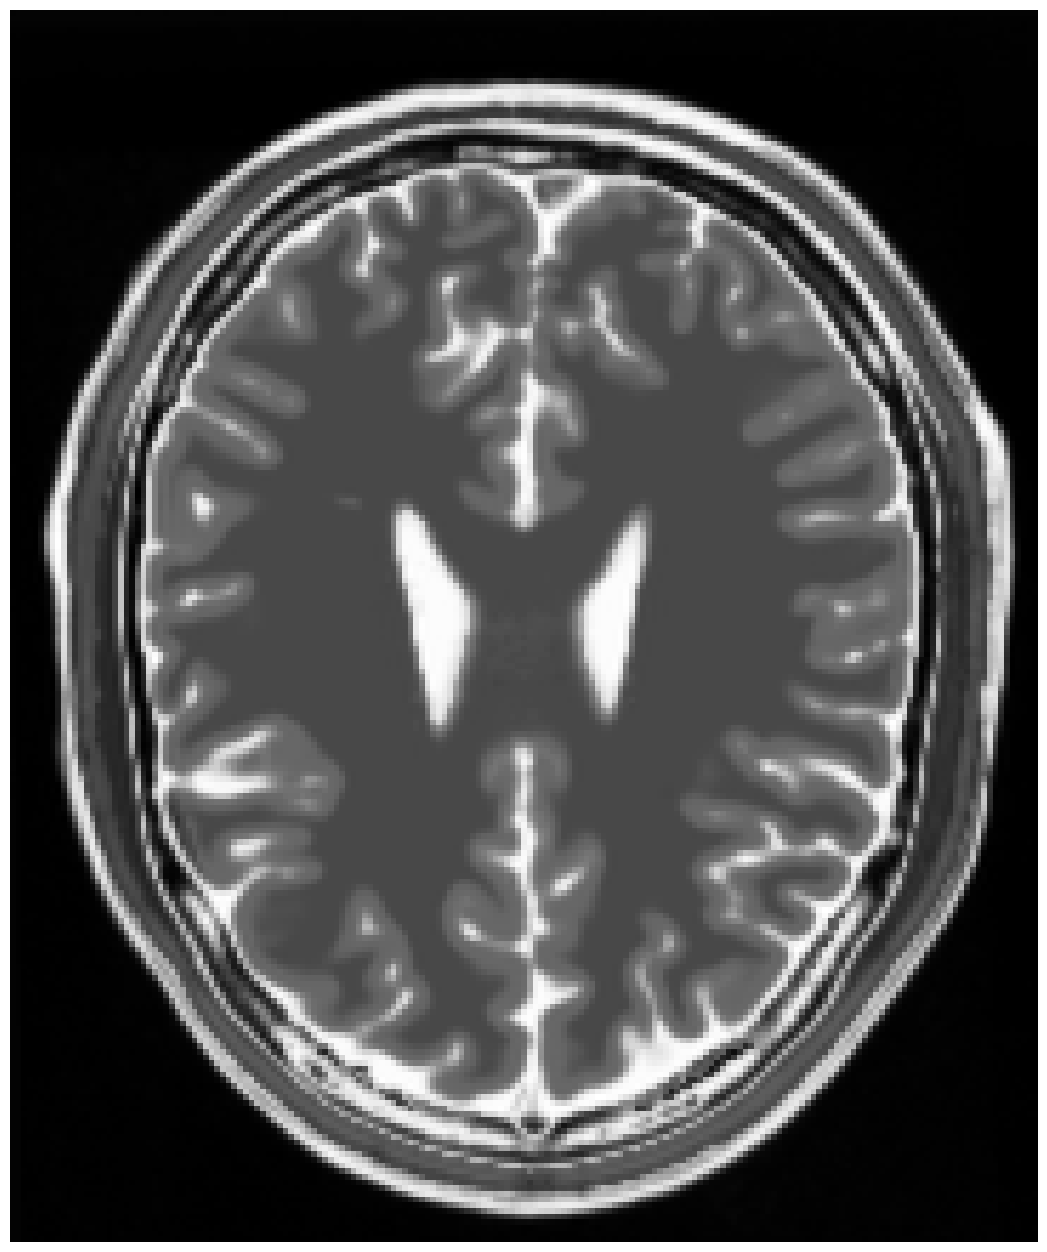

In [42]:
plt.figure(figsize=(16, 16))
plt.imshow(t2_data[0], cmap='gray')
plt.axis('off')
plt.show()

In [43]:
t1_data_resize = np.zeros((t1_data.shape[0], 256, 256))
for index, img in enumerate(t1_data):
    t1_data_resize[index, :, :] = resize(img, (256, 256))
t1_data_resize.shape

(43, 256, 256)

In [44]:
t2_data_resize = np.zeros((t2_data.shape[0], 256, 256))
for index, img in enumerate(t2_data):
    t2_data_resize[index, :, :] = resize(img, (256, 256))
t2_data_resize.shape

(46, 256, 256)

In [45]:
t1_data_resize = t1_data_resize.reshape(t1_data_resize.shape[0], 256, 256, 1).astype('float32')
t2_data_resize = t2_data_resize.reshape(t2_data_resize.shape[0], 256, 256, 1).astype('float32')

In [46]:
t1_data_resize = tf.data.Dataset.from_tensor_slices(t1_data_resize).shuffle(t1_data.shape[0], seed=42).batch(BATCH_SIZE)
t2_data_resize = tf.data.Dataset.from_tensor_slices(t2_data_resize).shuffle(t1_data.shape[0], seed=42).batch(BATCH_SIZE)

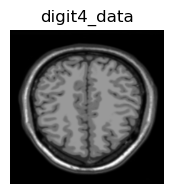

In [47]:
sample_t1_data = next(iter(t1_data_resize))
plt.figure(figsize=(2, 2))
plt.imshow(sample_t1_data[0].numpy()[:, :, 0], cmap='gray')
plt.title('digit4_data')
plt.axis('off')
plt.show()

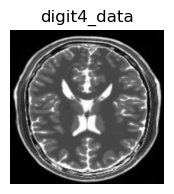

In [48]:
sample_t2_data = next(iter(t2_data_resize))
plt.figure(figsize=(2, 2))
plt.imshow(sample_t2_data[0].numpy()[:, :, 0], cmap='gray')
plt.title('digit4_data')
plt.axis('off')
plt.show()

## Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

In [49]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [50]:
def unet_generator():
   
    down_stack = [
      downsample(64, 4, apply_norm=False), 
      downsample(128, 4), 
      downsample(256, 4),  
      downsample(512, 4),  
      downsample(512, 4), 
      downsample(512, 4),  
      downsample(512, 4),  
      downsample(512, 4),  
    ]
                  #create a stack of downsample models
    up_stack = [
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4),  
      upsample(256, 4),  
      upsample(128, 4),  
      upsample(64, 4),  
               ] #create a stack of upsample models
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') 
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [51]:
generator_g = unet_generator() #initialise the generator
generator_f = unet_generator() #initialise the generator

In [52]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4,  False)(x)  #write your code to downsample X
    down2 = downsample(128, 4)(down1)     #write your code to downsample down1
    down3 = downsample(256, 4)(down2)     #write your code to downsample down2
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  
    return tf.keras.Model(inputs=inp, outputs=last) #create the model using input & output layer

In [53]:
discriminator_x = discriminator() #initialise the discriminator
discriminator_y = discriminator() #initialise the discriminator

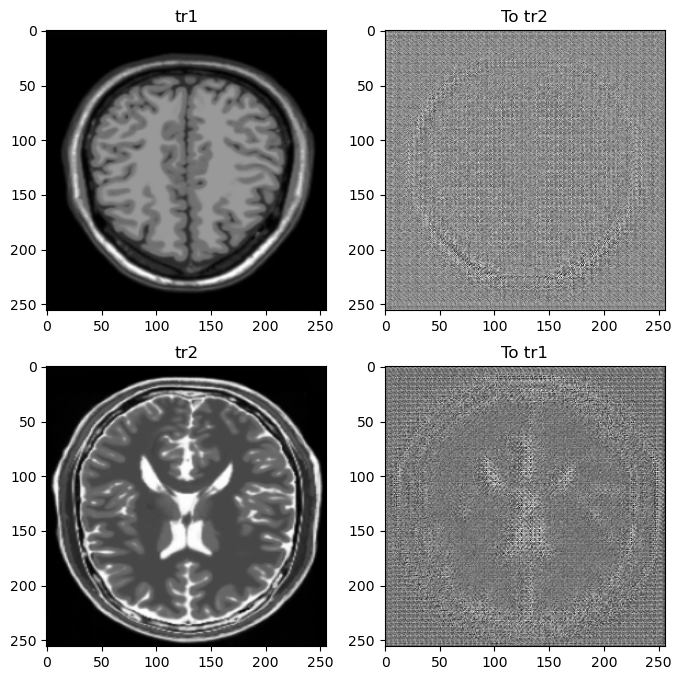

In [54]:
to_t2 = generator_g(sample_t1_data)
to_t1 = generator_f(sample_t2_data)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_t1_data, to_t2, sample_t2_data, to_t1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

In [55]:
LAMBDA = 10

In [56]:
# Using Binarycross entropy with logits true
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [57]:
# calculating discriminator loss by summing the real and generated
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real) #write your code here
    generated_loss = loss_obj(tf.zeros_like(generated), generated) #write your code here
    total_disc_loss = real_loss + generated_loss #write your code here
    return total_disc_loss * 0.5

In [58]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [59]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image)) #write your code here
    return LAMBDA * loss1

In [60]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [61]:
# Optimizer with learning rate 0.0001 for generator and discriminator
generator_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

In [62]:
EPOCHS = 40 #"Your Number of Epochs Here"

In [63]:

checkpoint_path = './checkpoints'  
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [64]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [65]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)  #write your code to generate images using Generator_g on real_x
        cycled_x = generator_f(fake_y, training=True) #write your code to generate images susiing Generator_f on fake_y
        
        fake_x =  generator_f(real_y, training=True) #write your code to generate images using Generator_f on real_y
        cycled_y = generator_g(fake_x, training=True) #write your code to generate images using Generator_g on fake_x
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True) #write your code to generate images using Generator_f on real_x
        same_y = generator_g(real_y, training=True) #write your code to generate images using Generator_g on real_y
        
        disc_real_x =  discriminator_x(real_x, training=True) #write your code to discriminate images using Discriminator_x on real_x
        disc_real_y = discriminator_y(real_y, training=True) #write your code to discriminate images using Discriminator_y on real_y
        
        disc_fake_x = discriminator_x(fake_x, training=True) #write your code to discriminate images using Discriminator_x on fake_x
        disc_fake_y = discriminator_y(fake_y, training=True) #write your code to discriminate images using Discriminator_y on fake_y
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y) # calculate the generator_loss for disc_fake_
        gen_f_loss = generator_loss(disc_fake_x) # calculate the generator_loss for disc_fake_X 
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
 #calculate the total cycle loss
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # calculate the discriminator_loss for disc_fake_x wrt disc_real_x
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) # calculate the discriminator_loss foor disc_fake_y wrt disc_real_y
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables) #write your code here
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables) #write your code here
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables) #write your code here
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
 #write your code here
    
    # Apply the gradients to the optimizer
    
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables)) #write your code here
    


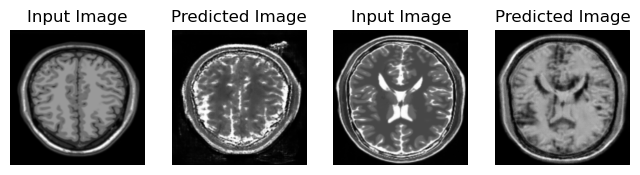

Saving checkpoint for epoch 1 at ./checkpoints\ckpt-26


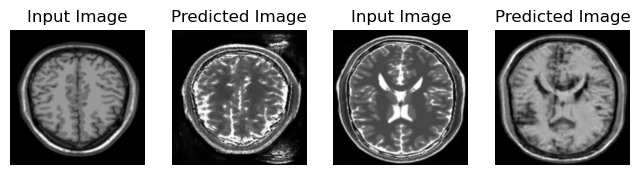

Saving checkpoint for epoch 2 at ./checkpoints\ckpt-27


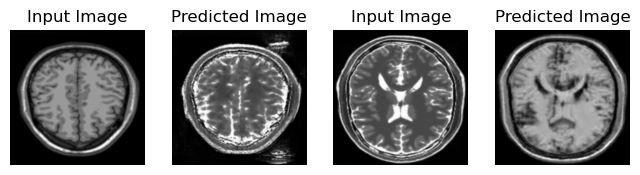

Saving checkpoint for epoch 3 at ./checkpoints\ckpt-28


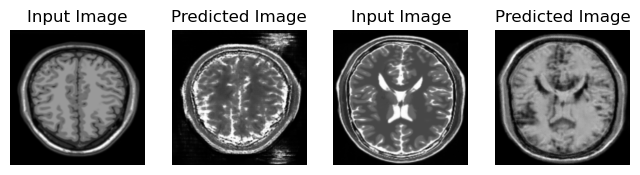

Saving checkpoint for epoch 4 at ./checkpoints\ckpt-29


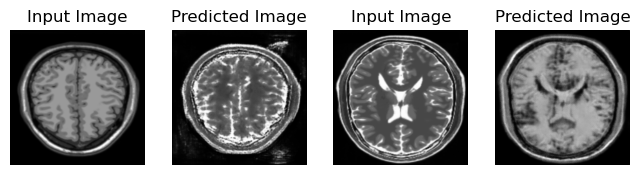

Saving checkpoint for epoch 5 at ./checkpoints\ckpt-30


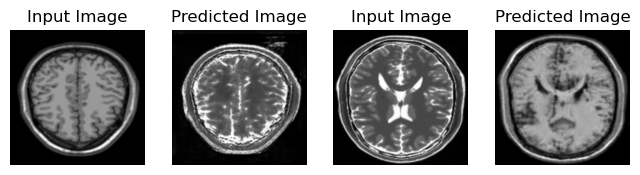

Saving checkpoint for epoch 6 at ./checkpoints\ckpt-31


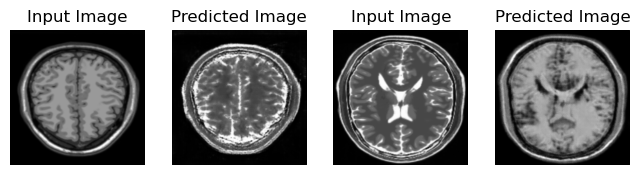

Saving checkpoint for epoch 7 at ./checkpoints\ckpt-32


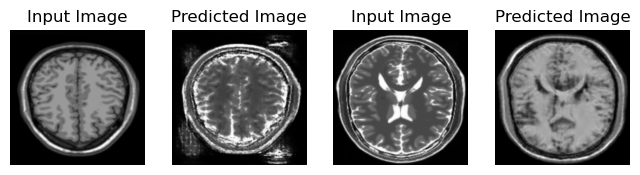

Saving checkpoint for epoch 8 at ./checkpoints\ckpt-33


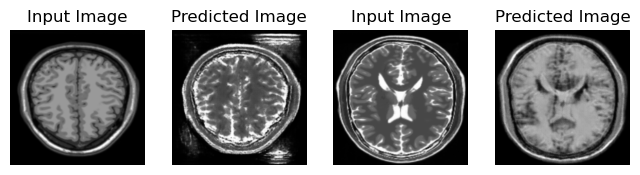

Saving checkpoint for epoch 9 at ./checkpoints\ckpt-34


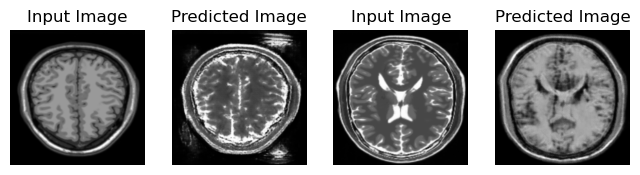

Saving checkpoint for epoch 10 at ./checkpoints\ckpt-35


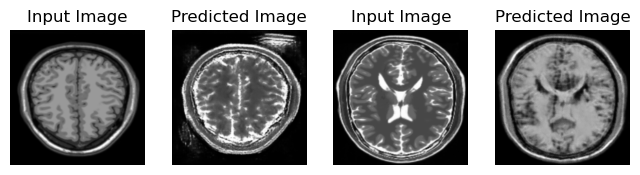

Saving checkpoint for epoch 11 at ./checkpoints\ckpt-36


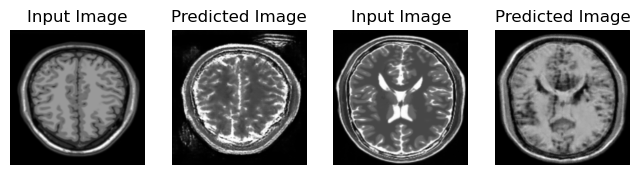

Saving checkpoint for epoch 12 at ./checkpoints\ckpt-37


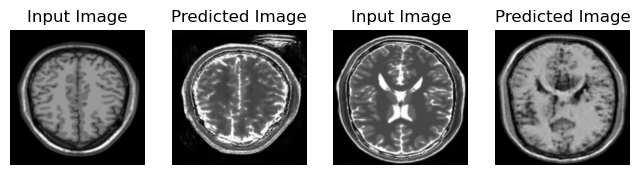

Saving checkpoint for epoch 13 at ./checkpoints\ckpt-38


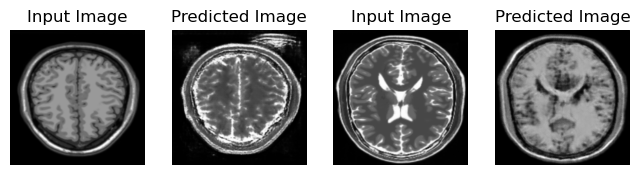

Saving checkpoint for epoch 14 at ./checkpoints\ckpt-39


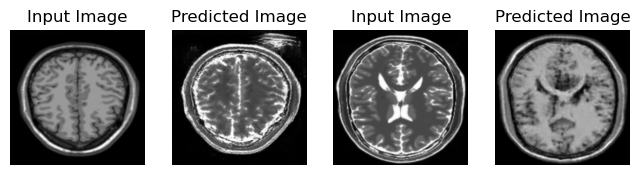

Saving checkpoint for epoch 15 at ./checkpoints\ckpt-40


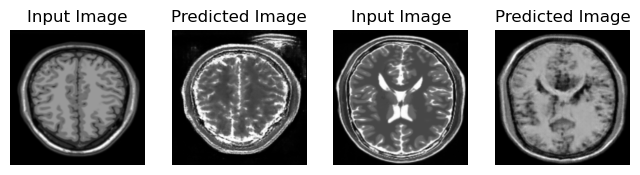

Saving checkpoint for epoch 16 at ./checkpoints\ckpt-41


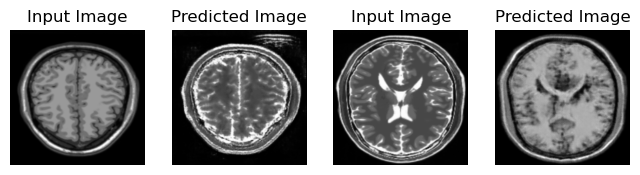

Saving checkpoint for epoch 17 at ./checkpoints\ckpt-42


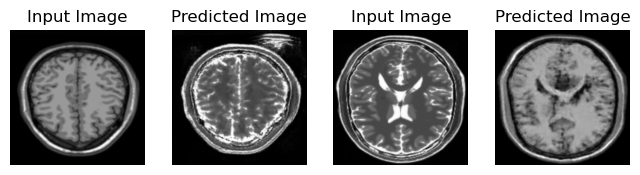

Saving checkpoint for epoch 18 at ./checkpoints\ckpt-43


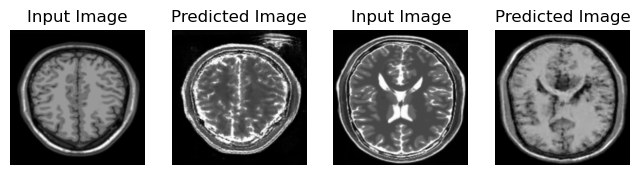

Saving checkpoint for epoch 19 at ./checkpoints\ckpt-44


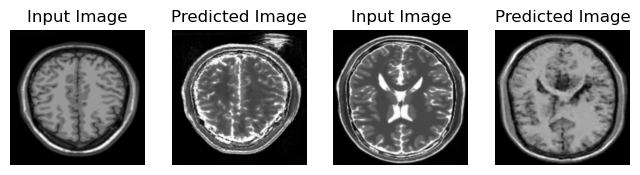

Saving checkpoint for epoch 20 at ./checkpoints\ckpt-45


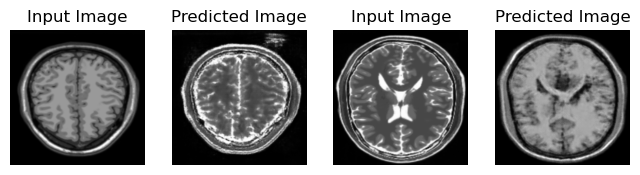

Saving checkpoint for epoch 21 at ./checkpoints\ckpt-46


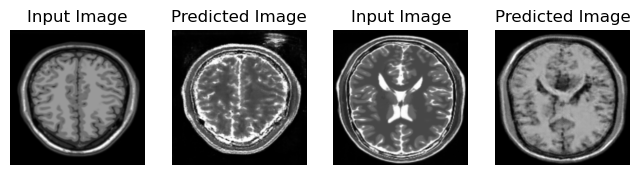

Saving checkpoint for epoch 22 at ./checkpoints\ckpt-47


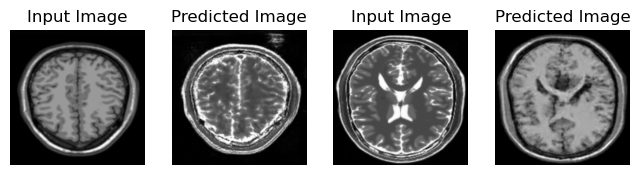

Saving checkpoint for epoch 23 at ./checkpoints\ckpt-48


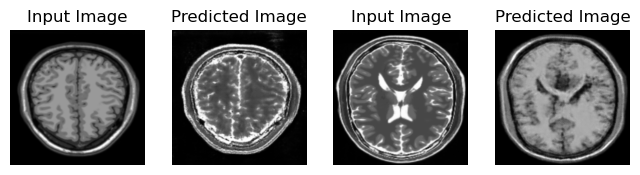

Saving checkpoint for epoch 24 at ./checkpoints\ckpt-49


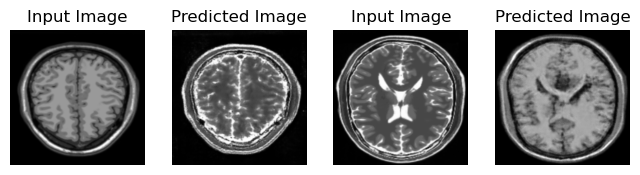

Saving checkpoint for epoch 25 at ./checkpoints\ckpt-50


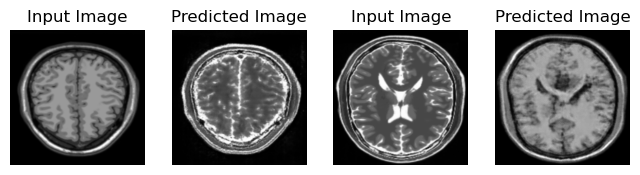

Saving checkpoint for epoch 26 at ./checkpoints\ckpt-51


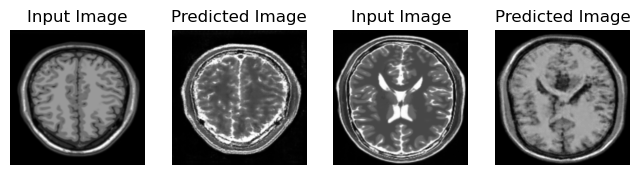

Saving checkpoint for epoch 27 at ./checkpoints\ckpt-52


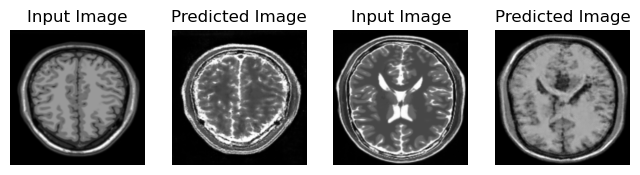

Saving checkpoint for epoch 28 at ./checkpoints\ckpt-53


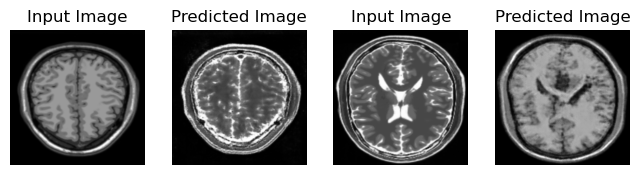

Saving checkpoint for epoch 29 at ./checkpoints\ckpt-54


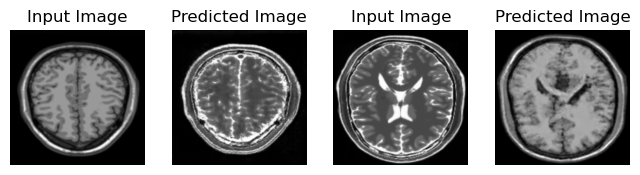

Saving checkpoint for epoch 30 at ./checkpoints\ckpt-55


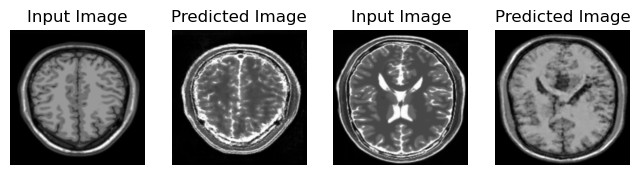

Saving checkpoint for epoch 31 at ./checkpoints\ckpt-56


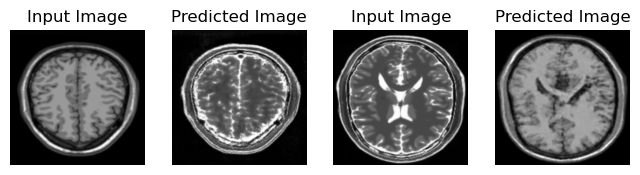

Saving checkpoint for epoch 32 at ./checkpoints\ckpt-57


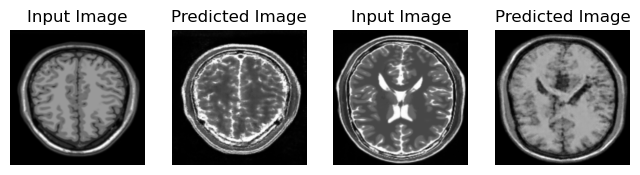

Saving checkpoint for epoch 33 at ./checkpoints\ckpt-58


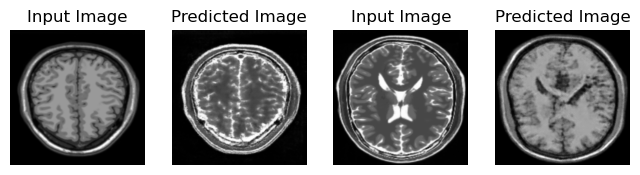

Saving checkpoint for epoch 34 at ./checkpoints\ckpt-59


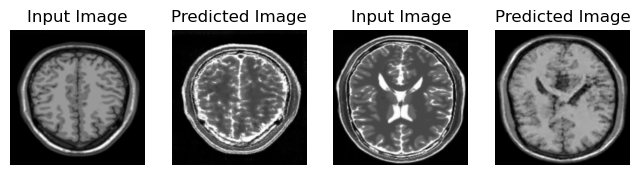

Saving checkpoint for epoch 35 at ./checkpoints\ckpt-60


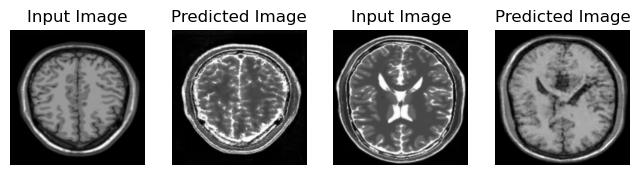

Saving checkpoint for epoch 36 at ./checkpoints\ckpt-61


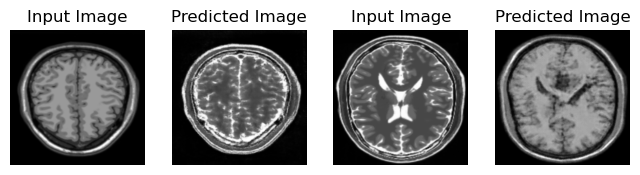

Saving checkpoint for epoch 37 at ./checkpoints\ckpt-62


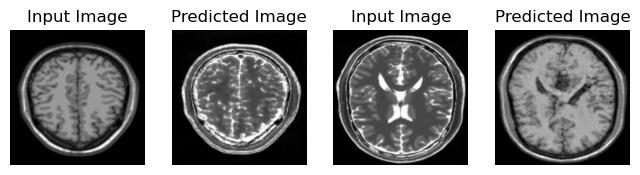

Saving checkpoint for epoch 38 at ./checkpoints\ckpt-63


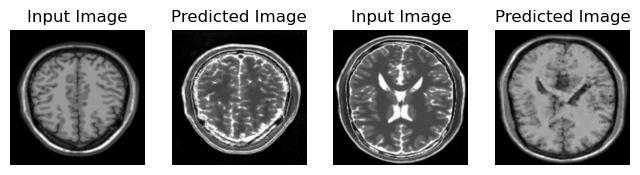

Saving checkpoint for epoch 39 at ./checkpoints\ckpt-64


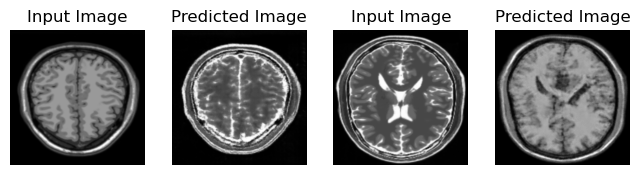

Saving checkpoint for epoch 40 at ./checkpoints\ckpt-65


In [66]:
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((t1_data_resize, t2_data_resize)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_t1_data, generator_f, sample_t2_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

In [67]:
anim_file = 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_24680\3274524612.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_24680\3274524612.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



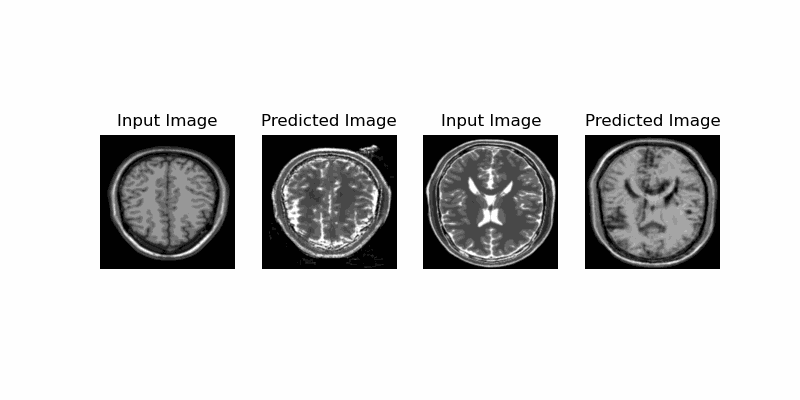

In [68]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)